### University of Washington: Machine Learning and Statistics 

# Lecture 6:  Density Estimation

Andrew Connolly and Stephen Portillo

##### Resources for this notebook include:
- [Textbook](https://press.princeton.edu/books/hardcover/9780691198309/statistics-data-mining-and-machine-learning-in-astronomy) Chapter 8. 
- [astroML website](https://www.astroml.org/index.html)

This notebook is developed based on material from A. Connolly, Z. Ivezic, M. Juric, S. Portillo, G. Richards, B. Sipocz, J. VanderPlas, D. Hogg, Killian Weinberger and many others.

The notebook and assoociated material are available from [github](https://github.com/uw-astro/astr-598a-win22).

Make sure you are using the latest version of astroML

> pip install --pre -U astroml

<a id='toc'></a>

## This notebook includes:


Density Estimation: K-means, Kernel Density Estimation, K-nearest neighbors


- [K-means](#kmeans) 

- [Kernel Density Estimation](#kde)
- [K-nearest neighbors](#knn) 



## Unsupervised vs. Supervised Classification  

In density estimation, we estimate joint probability distributions from multivariate data sets to identify the inherent clustering. This is essentially **unsupervised classification**. Here “unsupervised” means that there is no prior information about the number and properties of clusters. In other words, this method is search for unknown structure in your (multi-dimensional) dataset.

If we have labels for some of these data points (e.g., an object is tall, short, red, or blue), we can develop a relationship between the label and the properties of a source. This is **supervised classification**. In other words, this method is finding objects in  your (multi-dimensional) dataset that "look like" objects in your training set. 

Classification, regression, and density estimation are all related. For example, the regression function $\hat{y} = f(y|\vec{x})$ is the best estimated value of $y$ given a value of $\vec{x}$. In classification $y$ is categorical and $f(y|\vec{x})$ is called the _discriminant function_
 

## K-means clustering algorithm

![](figures/kmeans.png) 

Question is: how do we find clusters or estimate density efficiently?

<u> The _K-means_ algorithm </u>

The first approach for finding clusters that is always taught is $K$-means (simple and works well)

$K$-means partitions points into $K$ disjoint subsets ($C_k$) with each subset containing $N_k$
points 


It minimizes the objective/cost/likelihood function,
$\sum_{k=1}^K \sum_{i \in C_k} || x_i - \mu_k ||^2$

$\mu_k = \frac{1}{N_k} \sum_{i \in C_k} x_i$ is the mean of the
points in set $C_k$


_Procedure:_

1. define the number of clusters $K$
2. choose the centroid, $\mu_k$, of each of the $K$ clusters
3. assign each point to the cluster that it is closest to
4. update the centroid of each cluster by recomputing $\mu_k$ according to the new assignments.
5. goto (3) until there are no new assignments.

Global optima are not guaranteed but the process never increases the sum-of-squares error.

Typically run multiple times with different starting values for the
centroids of $C_k$.

We will start with looking at the density of stars as a function of metalicity and use scikit-learns preprocessing.StandardScaler function to normalize each feature

In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

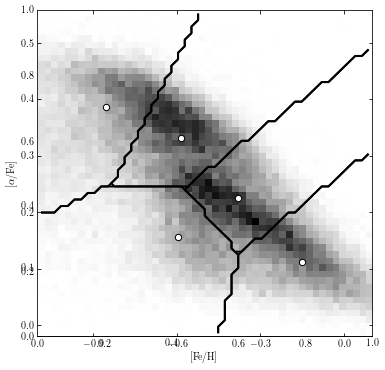

In [34]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse
from scipy.stats import norm

from sklearn.cluster import KMeans
from sklearn import preprocessing

from astroML.datasets import fetch_sdss_sspp

#------------------------------------------------------------
# Get data
data = fetch_sdss_sspp(cleaned=True)
X = np.vstack([data['FeH'], data['alphFe']]).T

# truncate dataset for speed
X = X[::5]

#------------------------------------------------------------
# Compute a 2D histogram  of the input
H, FeH_bins, alphFe_bins = np.histogram2d(data['FeH'], data['alphFe'], 50)

#------------------------------------------------------------
# Compute the KMeans clustering
n_clusters = 5

scaler = preprocessing.StandardScaler()
clf = KMeans(n_clusters)
clf.fit(scaler.fit_transform(X.astype("float")))

#------------------------------------------------------------
# Visualize the results
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot()

# plot density
ax = plt.axes()
ax.imshow(H.T, origin='lower', interpolation='nearest', aspect='auto',
          extent=[FeH_bins[0], FeH_bins[-1],
                  alphFe_bins[0], alphFe_bins[-1]],
          cmap=plt.cm.binary)

# plot cluster centers
cluster_centers = scaler.inverse_transform(clf.cluster_centers_)
ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1],
           s=40, c='w', edgecolors='k')

# plot cluster boundaries
FeH_centers = 0.5 * (FeH_bins[1:] + FeH_bins[:-1])
alphFe_centers = 0.5 * (alphFe_bins[1:] + alphFe_bins[:-1])

Xgrid = np.meshgrid(FeH_centers, alphFe_centers)
Xgrid = np.array(Xgrid).reshape((2, 50 * 50)).T

H = clf.predict(scaler.transform(Xgrid)).reshape((50, 50))

for i in range(n_clusters):
    Hcp = H.copy()
    flag = (Hcp == i)
    Hcp[flag] = 1
    Hcp[~flag] = 0

    ax.contour(FeH_centers, alphFe_centers, Hcp, [-0.5, 0.5],
               linewidths=2, colors='k')

ax.xaxis.set_major_locator(plt.MultipleLocator(0.3))
ax.set_xlim(-1.101, 0.101)
ax.set_ylim(alphFe_bins[0], alphFe_bins[-1])

ax.set_xlabel(r'$\rm [Fe/H]$')
ax.set_ylabel(r'$\rm [\alpha/Fe]$')

plt.show()

***How do you choose the number of clusters?***

## Estimating the density non-parametrically

Effectively an enhancement to histograms (piecewise constant or top-hat kernel) in multidimensional space

**Kernel Density Estimation**

$N(x) = \frac{1}{Nh^D} \sum_{i=1}^N  K\left( \frac{d(x,x_i)}{h} \right),$

K: kernel (defined by the bandwidth h) is any smooth function which is positive at all values

Too narrow a kernel, too spiky the results (high variance)

Too broad a kernel, too smooth or washed out the results (bias)

_Common kernels_

Gaussian: $ K(u) = \frac{1}{(2\pi)^{D/2}} e^{- u^2 / 2}$ D: dimension

Tophat: $ K(u) = \left\{
  \begin{array}{ll}
    \frac{1}{V_D(r)} & {\rm if}\ u \le r,\\
    0                & {\rm if}\ u > r,
  \end{array}
  \right.$
  
Exponential: $  K(u) = \frac{1}{D!\, V_D(r)}e^{-|u|}$ 

with $V_D(r)$ the volume of a hypersphere radius $r$;  $V_D(r) = \frac{2r^D\pi^{D/2}}{D\  \Gamma(D/2)}$

<img src="figures/funcs.png">

Perhaps surprisingly the primary feature is the bandwidth of these distributions not the exact shape. Choosing the bandwidth is usually done through cross-validation




To demonstrate this, the plot projects galaxies in SDSS "Great Wall" as scatted points by their spatial locations onto the equatorial plane (declination ~ $0^o$). The graph below shows the location of each point, but it is hard to get "clustered information" from.

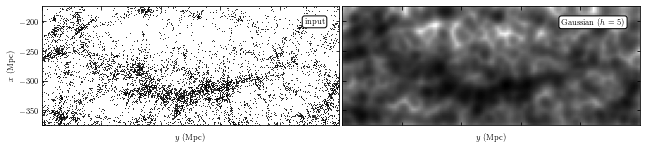

In [8]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

from sklearn.neighbors import KernelDensity

from astroML.datasets import fetch_great_wall

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

#------------------------------------------------------------
# Fetch the great wall data
X = fetch_great_wall()

#------------------------------------------------------------
# Create  the grid on which to evaluate the results
Nx = 50
Ny = 125
xmin, xmax = (-375, -175)
ymin, ymax = (-300, 200)

#------------------------------------------------------------
# Evaluate for several models
Xgrid = np.vstack(map(np.ravel, np.meshgrid(np.linspace(xmin, xmax, Nx),
                                            np.linspace(ymin, ymax, Ny)))).T

kernels = ['gaussian']
dens = []

kde1 = KernelDensity(bandwidth=5, kernel='gaussian')
log_dens1 = kde1.fit(X).score_samples(Xgrid)
dens1 = X.shape[0] * np.exp(log_dens1).reshape((Ny, Nx))

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(10, 5))
fig.subplots_adjust(left=0.12, right=0.95, bottom=0.2, top=0.9,
                    hspace=0.01, wspace=0.01)

# First plot: scatter the points
ax1 = plt.subplot(221, aspect='equal')
ax1.scatter(X[:, 1], X[:, 0], s=1, lw=0, c='k')
ax1.text(0.95, 0.9, "input", ha='right', va='top',
         transform=ax1.transAxes,
         bbox=dict(boxstyle='round', ec='k', fc='w'))

# Second plot: gaussian kernel
ax2 = plt.subplot(222, aspect='equal')
ax2.imshow(dens1.T, origin='lower', norm=LogNorm(),
           extent=(ymin, ymax, xmin, xmax), cmap=plt.cm.binary)
ax2.text(0.95, 0.9, "Gaussian $(h=5)$", ha='right', va='top',
         transform=ax2.transAxes,
         bbox=dict(boxstyle='round', ec='k', fc='w'))

for ax in [ax1, ax2]:
    ax.set_xlim(ymin, ymax - 0.01)
    ax.set_ylim(xmin, xmax)

for ax in [ax1, ax2]:
    ax.xaxis.set_major_formatter(plt.NullFormatter())
    ax.set_xlabel('$y$ (Mpc)')

for ax in [ax2]:
    ax.yaxis.set_major_formatter(plt.NullFormatter())

for ax in [ax1]:
    ax.set_ylabel('$x$ (Mpc)')

plt.show()

##### Exercise: Use Kernel Density Estimation with a top-hat, Gaussian, and exponential kernel on the color-magnitude diagrams (CMDs) of the two data sets (Field A and Field B) from Homework 7. Plot the density for each CMD in each panel (i.e., g-r on the x axis and g on the y axis) - a Hess diagrams.

Experiment with different kernel bandwidths, plotting one that visually seems "best" (i.e., a good balance of bias vs. variance) for each kernel.

Don't forget to change the figure size so that individual panels have aspect ratios closer to what is common for color-magnitude diagrams (i.e., x:y ~ 4:6 or so).

Subtract the "best" density for Field B from A to see if there are structures present in the CMD - what are they?

Text(0, 0.5, 'g')

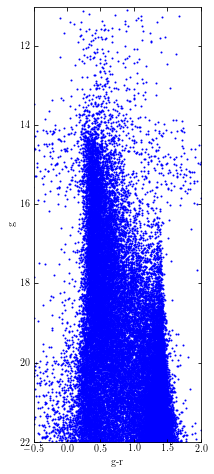

In [32]:
#Hess diagrams with SDSS data
import pandas as pd
fieldA = pd.read_csv('data/fieldA.csv')
fieldB = pd.read_csv('data/fieldB.csv')

# Add a column for color
fieldA['g-r'] = fieldA.g - fieldA.r
fieldB['g-r'] = fieldB.g - fieldB.r

plt.figure(figsize=(3, 8))
plt.scatter(fieldA['g-r'],fieldA['g'], s=1, alpha=1)
plt.xlim(-0.5, 2)
plt.ylim(22,11)
plt.xlabel('g-r')
plt.ylabel('g')

## Nearest neighbor estimation

Simple (simplest?) density estimator heavily used in astrophysics (cluster detection, large scale structure measures), originally proposed by [Dressler et al. 1980](https://ui.adsabs.harvard.edu/abs/1980ApJ...236..351D/abstract) . 

For each point we find the distance to the $K$th-nearest neighbor, $d_K$. **Note: we are not choosing clusters here** In this method, the implied point density at an arbitrary position x is estimated as

$$\hat{f_K}(x) = \frac{K}{V_D(d_K)}$$

where $V_D$ is evaluated volume, and D is the problem dimensionality.  
  
By taking the assumption that the underlying density field is locally constant, we can further simplify this method as

$$\hat{f_K}(x) = \frac{C}{d_K^D}$$

where C is a scaling factor evaluated by requiring that the sum of the product of $\hat{f_K}(x)$ and
pixel volume is equal to the total number of data points.

The error on $\hat{f}_K(x)$ is 

$$\sigma_f = K^{1/2}/V_D (d_K)$$

The fractional (relative) error is 

$$\sigma_f/\hat{f} = 1/K^{1/2}$$.

We can see that the
*   fractional accuracy increases with $K$ at  expense of the spatial resolution (bias-variance trade-off)
*   effective resolution scales with $K^{1/D}$

The method can be improved by considering distances to _all_ $K$ nearest neighbors 

$$\hat{f}_K(x) = {C \over \sum_{i=1}^K d_i^D}$$

The normalization when  computing local density without regard to overall mean density is

$$C  =  \frac{K\, (K + 1)}{2 V_D(r)}$$

In this method, we can change parameter k to get different estimation result. K should be at least 5 because the estimator is biased and has a large variance for smaller K; see [Casertano, S. and Hut, P.](https://ui.adsabs.harvard.edu/abs/1985ApJ...298...80C/abstract)

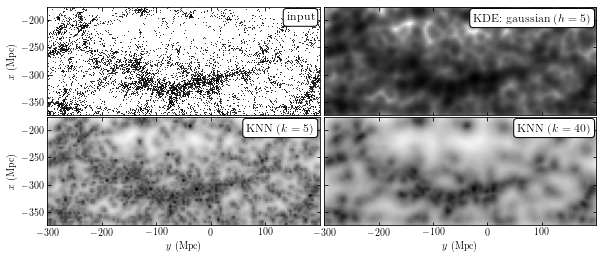

In [33]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

from sklearn.neighbors import KernelDensity
from astroML.density_estimation import KNeighborsDensity

#------------------------------------------------------------
# Create  the grid on which to evaluate the results
Nx = 50
Ny = 125
xmin, xmax = (-375, -175)
ymin, ymax = (-300, 200)

#------------------------------------------------------------
# Evaluate for several models
Xgrid = np.vstack(map(np.ravel, np.meshgrid(np.linspace(xmin, xmax, Nx),
                                            np.linspace(ymin, ymax, Ny)))).T

kde = KernelDensity(kernel='gaussian', bandwidth=5)
log_pdf_kde = kde.fit(X).score_samples(Xgrid).reshape((Ny, Nx))
dens_KDE = np.exp(log_pdf_kde)

knn5 = KNeighborsDensity('bayesian', 5)
dens_k5 = knn5.fit(X).eval(Xgrid).reshape((Ny, Nx))

knn40 = KNeighborsDensity('bayesian', 40)
dens_k40 = knn40.fit(X).eval(Xgrid).reshape((Ny, Nx))

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(9, 4.0))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.14, top=0.9,
                    hspace=0.01, wspace=0.01)

# First plot: scatter the points
ax1 = plt.subplot(221, aspect='equal')
ax1.scatter(X[:, 1], X[:, 0], s=1, lw=0, c='k')
ax1.text(0.98, 0.95, "input", ha='right', va='top',
         transform=ax1.transAxes, fontsize=12,
         bbox=dict(boxstyle='round', ec='k', fc='w'))

# Second plot: KDE
ax2 = plt.subplot(222, aspect='equal')
ax2.imshow(dens_KDE.T, origin='lower', norm=LogNorm(),
           extent=(ymin, ymax, xmin, xmax), cmap=plt.cm.binary)
ax2.text(0.98, 0.95, "KDE: gaussian $(h=5)$", ha='right', va='top',
         transform=ax2.transAxes, fontsize=12,
         bbox=dict(boxstyle='round', ec='k', fc='w'))

# Third plot: KNN, k=5
ax3 = plt.subplot(223, aspect='equal')
ax3.imshow(dens_k5.T, origin='lower', norm=LogNorm(),
           extent=(ymin, ymax, xmin, xmax), cmap=plt.cm.binary)
ax3.text(0.98, 0.95, "KNN $(k=5)$", ha='right', va='top',
         transform=ax3.transAxes, fontsize=12,
         bbox=dict(boxstyle='round', ec='k', fc='w'))

# Fourth plot: KNN, k=40
ax4 = plt.subplot(224, aspect='equal')
ax4.imshow(dens_k40.T, origin='lower', norm=LogNorm(),
           extent=(ymin, ymax, xmin, xmax), cmap=plt.cm.binary)
ax4.text(0.98, 0.95, "KNN $(k=40)$", ha='right', va='top',
         transform=ax4.transAxes, fontsize=12,
         bbox=dict(boxstyle='round', ec='k', fc='w'))

for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xlim(ymin, ymax - 0.01)
    ax.set_ylim(xmin, xmax)

for ax in [ax1, ax2]:
    ax.xaxis.set_major_formatter(plt.NullFormatter())

for ax in [ax3, ax4]:
    ax.set_xlabel('$y$ (Mpc)')

for ax in [ax2, ax4]:
    ax.yaxis.set_major_formatter(plt.NullFormatter())

for ax in [ax1, ax3]:
    ax.set_ylabel('$x$ (Mpc)')

plt.show()

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm, Normalize

from scipy.spatial import cKDTree
from scipy.stats import gaussian_kde

from astroML.datasets import fetch_great_wall

from sklearn.neighbors import KernelDensity

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=10, usetex=True)

def make_plots(X, h):
    #------------------------------------------------------------
    # Create  the grid on which to evaluate the results
    Nx = 250
    Ny = 250
    xmin, xmax = (-0.5, 2)
    ymin, ymax = (22, 14)

    #------------------------------------------------------------
    # Evaluate for several models
    Xgrid = np.vstack(map(np.ravel, np.meshgrid(np.linspace(xmin, xmax, Nx),
                                                np.linspace(ymin, ymax, Ny)))).T

    kernels = ['gaussian', 'tophat', 'exponential']
    dens = []

    kde1 = KernelDensity(h, kernel='gaussian')
    log_dens1 = kde1.fit(X).score_samples(Xgrid)
    dens1 = X.shape[0] * np.exp(log_dens1).reshape((Ny, Nx))

    kde2 = KernelDensity(h, kernel='tophat')
    log_dens2 = kde2.fit(X).score_samples(Xgrid)
    dens2 = X.shape[0] * np.exp(log_dens2).reshape((Ny, Nx))

    kde3 = KernelDensity(h, kernel='exponential')
    log_dens3 = kde3.fit(X).score_samples(Xgrid)
    dens3 = X.shape[0] * np.exp(log_dens3).reshape((Ny, Nx))

    #------------------------------------------------------------
    # Plot the results
    fig = plt.figure(figsize=(10, 15))
    fig.subplots_adjust(left=0.12, right=0.95, bottom=0.2, top=0.9,
                        hspace=0.1, wspace=0.1)

    # First plot: scatter the points
    ax1 = plt.subplot(221)
    ax1.scatter(X[:, 0], X[:, 1], s=1, lw=0, c='k')
    ax1.text(0.95, 0.9, "input", ha='right', va='top',
             transform=ax1.transAxes,
             bbox=dict(boxstyle='round', ec='k', fc='w'))

    # Second plot: gaussian kernel
    ax2 = plt.subplot(222)
    ax2.imshow(dens1, origin='lower', aspect='auto', norm=Normalize(),
               extent=(xmin, xmax, ymin, ymax), cmap=plt.cm.binary)
    ax2.text(0.95, 0.9, "Gaussian $(h=%.2f)$" % h, ha='right', va='top',
             transform=ax2.transAxes,
             bbox=dict(boxstyle='round', ec='k', fc='w'))

    # Third plot: top-hat kernel
    ax3 = plt.subplot(223)
    ax3.imshow(dens2, origin='lower', aspect='auto', norm=Normalize(),
               extent=(xmin, xmax, ymin, ymax), cmap=plt.cm.binary)
    ax3.text(0.95, 0.9, "top-hat $(h=%.2f)$" % h, ha='right', va='top',
             transform=ax3.transAxes,
             bbox=dict(boxstyle='round', ec='k', fc='w'))

    # Fourth plot: exponential kernel
    ax4 = plt.subplot(224)
    ax4.imshow(dens3, origin='lower', aspect='auto', norm=Normalize(),
               extent=(xmin, xmax, ymin, ymax), cmap=plt.cm.binary)
    ax4.text(0.95, 0.9, "exponential $(h=%.2f)$" % h, ha='right', va='top',
             transform=ax4.transAxes,
             bbox=dict(boxstyle='round', ec='k', fc='w'))

    for ax in [ax1, ax2, ax3, ax4]:
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)

    for ax in [ax1, ax2]:
        ax.xaxis.set_major_formatter(plt.NullFormatter())

    for ax in [ax3, ax4]:
        ax.set_xlabel('$g-r$')

    for ax in [ax2, ax4]:
        ax.yaxis.set_major_formatter(plt.NullFormatter())

    for ax in [ax1, ax3]:
        ax.set_ylabel('$g$')

    plt.show()
    
    return dens1

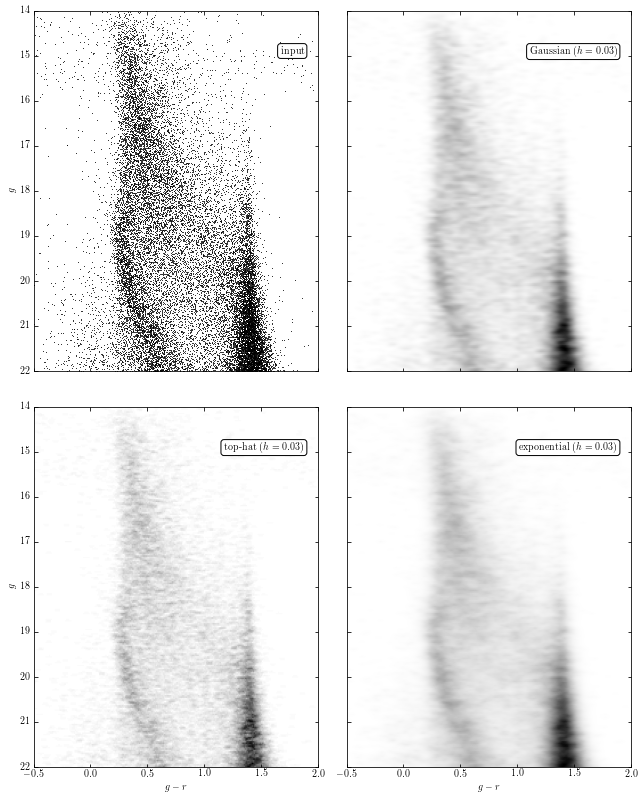

In [19]:
densityB = make_plots(fieldB[['g-r','g']].to_numpy(), 0.03)

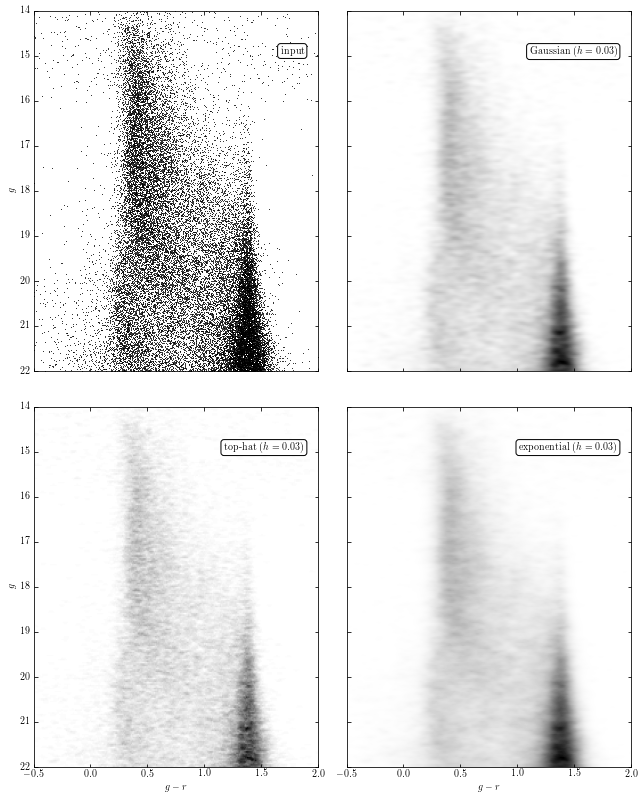

In [25]:
densityA = make_plots(fieldA[['g-r','g']].to_numpy(), 0.03)

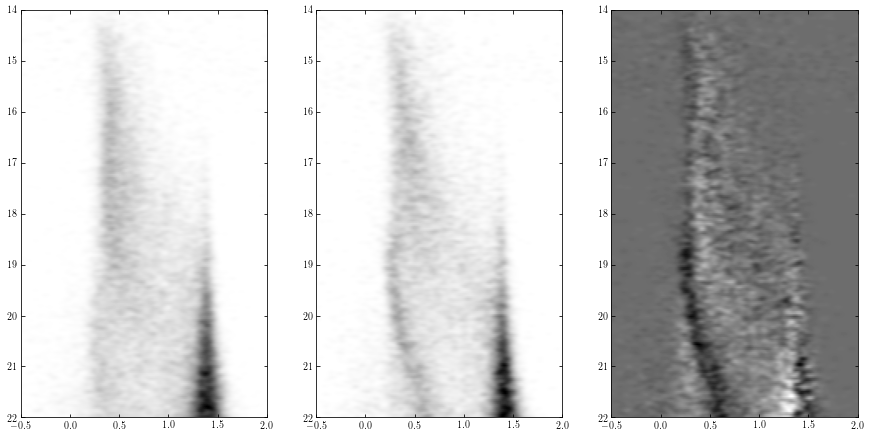

In [27]:
fig = plt.figure(figsize=(15, 7.5))
xmin, xmax = (-0.5, 2)
ymin, ymax = (22, 14)

ax = plt.subplot(131)
ax.imshow(densityA, origin='lower', aspect='auto', norm=Normalize(), 
              extent=(xmin, xmax, ymin, ymax), cmap=plt.cm.binary)

ax = plt.subplot(132)
ax.imshow(densityB, origin='lower', aspect='auto', norm=Normalize(), 
              extent=(xmin, xmax, ymin, ymax), cmap=plt.cm.binary)

ax = plt.subplot(133)
# note renormalization of the second image (fieldA)! 
ax.imshow(densityB-0.8*densityA, origin='lower', aspect='auto', norm=Normalize(), 
              extent=(xmin, xmax, ymin, ymax), cmap=plt.cm.binary)

plt.show()